# Homework 9 Prinicipal Component Regression and Partial Least Squares

## Part 1 - Data preparation

We start this homework with probably the most important step in data science: data preparation.
This week, we are going to investigate a data set that contains baseball data from the (North American) Major League during 1986 and 1987.

**Task**: Import the Hitters data set, available on the class web page and drop all rows containing missing values.

**Solution**:

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('./datasets/Hitters.csv').dropna(axis=0)

**Task**: Identify the three variables containing categorical variables and store their labels in a list `dummy_vars`.

**Solution**:

In [2]:
print(df.head())
print(df.info())
dummy_vars = ['League', 'Division', 'NewLeague']

   AtBat  Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  \
1    315    81      7    24   38     39     14    3449    835      69    321   
2    479   130     18    66   72     76      3    1624    457      63    224   
3    496   141     20    65   78     37     11    5628   1575     225    828   
4    321    87     10    39   42     30      2     396    101      12     48   
5    594   169      4    74   51     35     11    4408   1133      19    501   

   CRBI  CWalks League Division  PutOuts  Assists  Errors  Salary NewLeague  
1   414     375      N        W      632       43      10   475.0         N  
2   266     263      A        W      880       82      14   480.0         A  
3   838     354      N        E      200       11       3   500.0         N  
4    46      33      N        E      805       40       4    91.5         N  
5   336     194      A        W      282      421      25   750.0         A  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2

The pandas function `get_dummies` converts categorical variables into 0-1-dummy variables. This has been discussed in Chapter 3 (slide 112).

**Task**: Convert the three categorical variables in the dataset into dummy variables and store them in a new `DataFrame` called `df_dummy`.
Take a look at the new `DataFrame` using the method `head`.

**Solution**:

In [3]:
df_dummy=pd.get_dummies(df.loc[:,dummy_vars])
print(df_dummy.head())

   League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
1         0         1           0           1            0            1
2         1         0           0           1            1            0
3         0         1           1           0            0            1
4         0         1           1           0            0            1
5         1         0           0           1            1            0


Once you have done this, you should see that there are only two categories in each of the dummy variables.
Thus we should only include one of each into our final data frame.

**Task**: If you did everything right so far, the following code should execute without errors.

In [4]:
real_vars = ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',\
 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks','PutOuts', 'Assists', 'Errors']
dfX = pd.concat([df.loc[:,real_vars], df_dummy.loc[:,['League_A', 'Division_E', 'NewLeague_A']]], axis=1)
dfy = df.Salary

## Part 2 - Applying PCR

We have studied intensively PCA during the lab.
We will now combine this knowledge to perform a PCR.

According to [Wikipedia](https://en.wikipedia.org/wiki/Principal_component_regression), the PCR method may be broadly divided into three major steps:

1. Perform PCA on the observed data matrix for the explanatory variables to obtain the principal components, and then (usually) select a subset, based on some appropriate criteria, of the principal components so obtained for further use.
2. Now regress the observed vector of outcomes on the selected principal components as covariates, using ordinary least squares regression (linear regression) to get a vector of estimated regression coefficients (with dimension equal to the number of selected principal components).
3. Now transform this vector back to the scale of the actual covariates, using the selected PCA loadings (the eigenvectors corresponding to the selected principal components) to get the final PCR estimator (with dimension equal to the total number of covariates) for estimating the regression coefficients characterizing the original model.

**Task**: Scale the data using `StandardScaler` from `sklearn.preprocessing` and perform a (full) principal component analysis.

**Solution**:

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = StandardScaler().fit_transform(dfX)
y = dfy.values
pca = PCA().fit(X)
pc = pca.transform(X)

/LOCAL/Software/DataScience2018/miniconda3/envs/DS2018/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/LOCAL/Software/DataScience2018/miniconda3/envs/DS2018/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Now you should implement a loop over the number of principal components in your model.
We want to measure the quality by a cross-validated mean squared error using 10 folds.

**Task**:
Implement a loop over the number of principal components in your model.
Use the function `LinearRegression` as an estimator in `cross_val_score`.
As data, you should choose the first $j$ principal components.
Store the means of the mean squared errors in a list called `mse`.
You can use an appropriate `scoring` option.

**Solution**:

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
N = pca.n_components_

mse = []
mseminus = []
mseplus= []

for i in range(N):
    lr = LinearRegression()
    cvs = -1*cross_val_score(lr, pc[:,:i+1], y, cv=10, scoring='neg_mean_squared_error')
    mse.append(cvs.mean())
    mseminus.append(cvs.mean() - cvs.std())
    mseplus.append(cvs.mean() + cvs.std())
    print(cvs.mean())
print(mse)

123924.13089980236
125219.8186020469
125936.4971858609
123338.38059497124
120267.60729131897
118508.15848939035
118789.33335711621
119588.53890740126
120446.21349148313
122072.10474467053
122818.16267921469
123533.98633524493
123501.98662363982
119791.38051645881
120171.99674286325
116609.51312630426
116359.68557326551
115083.91154069177
116599.0136738026
[123924.13089980236, 125219.8186020469, 125936.4971858609, 123338.38059497124, 120267.60729131897, 118508.15848939035, 118789.33335711621, 119588.53890740126, 120446.21349148313, 122072.10474467053, 122818.16267921469, 123533.98633524493, 123501.98662363982, 119791.38051645881, 120171.99674286325, 116609.51312630426, 116359.68557326551, 115083.91154069177, 116599.0136738026]


**Task**: Determine the number of components for which the MSE is smallest.

**Solution**:

In [20]:
print('Minimum MSE for %d principal components' % (np.argmin(mse)+1))

Minimum MSE for 18 principal components


You should observe that the MSE is minimized by taking all but one principal components into consideration.
This corresponds to no dimensionality reduction at all, and simply performs a linear regression using all of the variables.
But we also observe that the values do not change very much, even using only one predictor yields a good fit.

**Task**: Plot the MSE against the number of components in your model.

**Solution**:

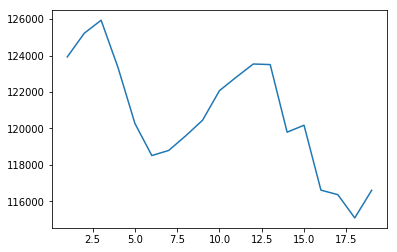

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
nrange = 1+np.asarray(range(N))
plt.plot(nrange,mse)
#plt.fill_between(nrange, mseminus, mseplus, alpha=0.2)

**Task**: Plot the percentage of variance explained by the first $j$ principal components against the number of principal components $j$.
You should use the attribute `explained_variance_ratio_` from your `PCA()`.

**Solution**:

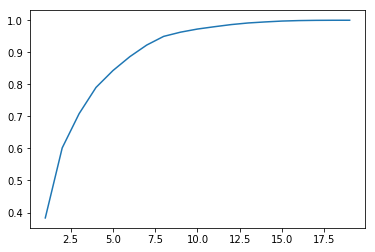

In [11]:
plt.plot(nrange,pca.explained_variance_ratio_.cumsum())

## Part 3 - Partial Least Squares

We want to apply partial least squares regression to this data set.
The function `PLSRegresssion` is provided by sklearn in the module `cross_decomposition`.

**Task**: Implement a loop over the number of components in your PLS regression model.
Use 10-fold cross-validation and store the means of the mean squared errors in a list called `mse`.
You can use an appropriate `scoring` option.

**Solution**:

In [15]:
from sklearn.cross_decomposition import PLSRegression

mse = []
mseminus = []
mseplus= []
for i in range(N):
    pls = PLSRegression(n_components=i+1)
    cvs = -1*cross_val_score(pls, X, y, cv=10, scoring='neg_mean_squared_error')
    mse.append(cvs.mean())
    mseminus.append(cvs.mean() - cvs.std())
    mseplus.append(cvs.mean() + cvs.std())
    print(cvs.mean())

122318.40415029772
120869.20847675091
120342.57274839829
119462.09544296702
122189.40601362588
120883.69908106592
119227.66421886161
115685.97332435506
115984.97109227064
115717.44911488841
115944.5092787043
115798.45521840893
116644.281406398
114824.45034020235
115712.18085901762
116097.3041963903
115564.97080748554
115676.89512608883
116599.01367380246


**Task**: Determine the number of components, for which the MSE is minimized.

In [16]:
print('Minimum MSE for %d components' % (np.argmin(mse)+1))

Minimum MSE for 14 components


**Task**: Plot the MSE against the number of components in your model.

**Solution**:

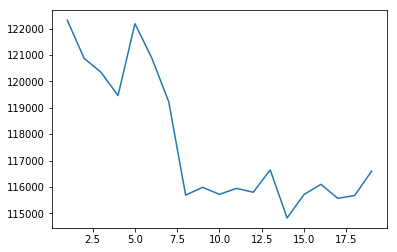

In [17]:
nrange = 1+np.asarray(range(N))
plt.plot(nrange,mse)
#plt.fill_between(nrange, mseminus, mseplus, alpha=0.2)

Again, we might draw a similar conclusion as for PCA.
Altough the MSE is minimized for 14 components, it is fairly low for other values as well.

**Task**: Finally, we want to take a look at the declared variance in the response in terms of the number of compontens used in the PLS regression.
You can copy your code from above, and only have to change the `scoring` option.
What do you observe?

**Observation**:

**Solution**:

In [22]:
r2 = []
for i in range(N):
    pls = PLSRegression(n_components=i+1)
    cvs = cross_val_score(pls, X, y, cv=10, scoring='r2')
    r2.append(cvs.mean())
    print(cvs.mean())

0.3780667415235278
0.3607969231863876
0.3547150074082742
0.3548712309562639
0.31615670731167844
0.31286545476024114
0.314770810251885
0.3292632601937663
0.32483001852412297
0.32200714771909256
0.3219131888346342
0.32325327123174763
0.3230365880832327
0.3343035025073656
0.3304193531453876
0.3279709712678428
0.3308248403083828
0.3304385050644538
0.3245713522246282


**Observation**: Most of the variance in the response variable is declared by taking only one component of partial least squares.